#### Notebook to make data for AmeriGeo 2021 presentation
by Cascade Tuholske

In [18]:
# Depedencies 
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import glob
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from matplotlib import rcParams
import os

In [2]:
# paths 
path = os.path.join('/home/cascade/cascade-scratch-forge/UEH-daily/stats')

In [6]:
glob.glob(path+'/*STATS.json')

['/home/cascade/cascade-scratch-forge/UEH-daily/stats/himax406_2d_STATS.json',
 '/home/cascade/cascade-scratch-forge/UEH-daily/stats/himax461_STATS.json',
 '/home/cascade/cascade-scratch-forge/UEH-daily/stats/himax406_STATS.json',
 '/home/cascade/cascade-scratch-forge/UEH-daily/stats/wbgtmax28_STATS.json',
 '/home/cascade/cascade-scratch-forge/UEH-daily/stats/wbgtmax32_STATS.json',
 '/home/cascade/cascade-scratch-forge/UEH-daily/stats/wbgtmax30_STATS.json']

## Regional Total

In [20]:
#### Regressions, no intercept addition is needed because we're using SK LEARN HERE 

def lm_func(df, col):
    
    "simple linear model of a time series data, returns coef"
    
    # Get Data
    X_year = np.array(df.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df.groupby('year')[col].sum()).reshape((-1, 1))

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit() 
        
    coef = int(model.params[1])
    #coef = int(coef)
            
    # R2 and P
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    return coef, round(r2, 2), round(p, 3)

In [22]:
#### Load Data
DATA = 'wbgtmax30' # UPDATE 

# file paths
DATA_IN = '/scratch/cascade/UEH-daily/stats/'  
FIG_OUT = '/home/cascade/projects/UrbanHeat/figures/'
FN_IN = os.path.join(DATA_IN,DATA+'_EXP.json') # all, not p05 since this is global
HI_STATS = pd.read_json(FN_IN, orient = 'split')

# Set scale
scale = 10**6

# File out
FN_OUT = os.path.join(FIG_OUT,'AmeriGeo-Fig1-'+DATA+'-Final.tiff')

In [23]:
# Drop IDs where days 1983 = 1 with none else. throws error in regressions 

print(len(HI_STATS))
only83 = HI_STATS.groupby('ID_HDC_G0')['tot_days'].sum() == 1 # sum up total days and find those with 1 day
only83 = list(only83[only83 == True].index) # make a list of IDs
sub = HI_STATS[HI_STATS['ID_HDC_G0'].isin(only83)] # subset those IDs
bad_ids = sub[(sub['year'] == 1983) & (sub['tot_days'] == 1)] # drop those from 1983 only
drop_list = list(bad_ids['ID_HDC_G0']) # make a list
HI_STATS= HI_STATS[~HI_STATS['ID_HDC_G0'].isin(drop_list)] # drop those from the list
print(len(HI_STATS))

303518
303178


In [24]:
#### Add In Meta Data (e.g. geographic data)
meta_fn = os.path.join('/home/cascade/projects/UrbanHeat/data/interim/','GHS-UCDB-IDS.csv')
meta_data = pd.read_csv(meta_fn)

#### Merge in meta
HI_STATS = HI_STATS.merge(meta_data, on = 'ID_HDC_G0', how = 'left')

In [25]:
# Subset for Ameri Geo countries
ameri_countries = ['Argentina', 'Bahamas', 'Belize', 'Brazil', 'Canada', 'Chile', 'Columbia', 'Costa Rica',
                  'Ecuador', 'El Salvador', 'Guatemala', 'Hondorus', 'Mexico', 'Panama', 'Paragua', 'Peru',
                  'United States', 'Uruguay']
ameri_stats = HI_STATS[HI_STATS['CTR_MN_NM'].isin(ameri_countries)]

In [26]:
np.unique(ameri_stats['CTR_MN_NM'])

array(['Argentina', 'Bahamas', 'Belize', 'Brazil', 'Canada', 'Costa Rica',
       'Ecuador', 'El Salvador', 'Guatemala', 'Mexico', 'Panama', 'Peru',
       'United States', 'Uruguay'], dtype=object)

Text(2.5, 1.1, '(C)')

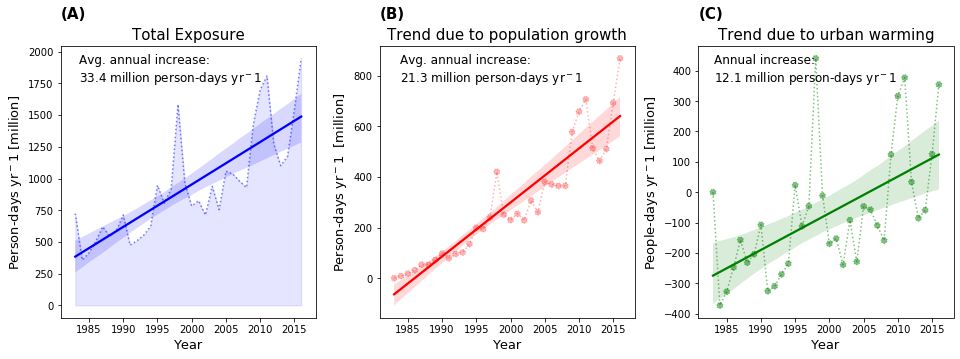

In [32]:
#### Make Figure & Save it

rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 

fig, axs = plt.subplots(1, 3, figsize = (16, 5), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)

## Years to calc increase in pdays / yr 
## yr_range = max(ameri_stats['year']) - min(ameri_stats['year']) + 1

## PLOT 1 - People Days
color = 'blue'
data = ameri_stats.groupby('year')['people_days'].sum() / scale
years = list(data.index)
axs[0].plot(data, color = color, linestyle = ':', alpha = 0.5)
axs[0].fill_between(years, data, color = color, alpha = 0.1, label='_nolegend_')
sns.regplot(years, data, color = color, ax = axs[0], scatter = False, truncate = True)
axs[0].set_title('Total Exposure', size = 15 )
axs[0].set_ylabel('Person-days $yr^-1$ [million]', fontsize = 13)
axs[0].set_xlabel('Year', fontsize = 13)

# Add text
coef, r2, p = lm_func(ameri_stats, 'people_days')
#text = str(round(coef/1000*yr_range, 1))+' B increase in\nperson-days'# ($R^2$=' + str(r2) + ')*'
text = 'Avg. annual increase:\n'+str(round(coef/scale, 1))+' million person-days $yr^-1$'
axs[0].text(0.07, .87, text, transform=axs[0].transAxes, size=12)
axs[0].text(0.00, 1.1, '(A)', transform=axs[0].transAxes, size=15, fontweight='bold')

## 2 PLOT 2 - People Days delta pop x days
color = 'red'
data = ameri_stats.groupby('year')['people_days_pop'].sum() / scale
axs[1].scatter(years, data, color = color, linestyle = ':', alpha = 0.3)
axs[1].plot(data, color = color, linestyle = ':', alpha = 0.3)
sns.regplot(years, data, color = color, ax = axs[1], scatter = False, truncate = True)
axs[1].set_title('Trend due to population growth', size = 15)
axs[1].set_ylabel('Person-days $yr^-1$  [million] ', fontsize = 13)
axs[1].set_xlabel('Year', fontsize = 13)

# Add text
coef, r2, p = lm_func(ameri_stats, 'people_days_pop')
#text = str(round(coef/1000*yr_range, 1))+' B increase in\nperson-days'# ($R^2$=' + str(r2) + ')*'
text = 'Avg. annual increase:\n'+str(round(coef/scale, 1))+' million person-days $yr^-1$'
axs[1].text(1.25+.08, .87, text, transform=axs[0].transAxes, size=12)
axs[1].text(1.25, 1.1, '(B)', transform=axs[0].transAxes, size=15, fontweight='bold')

## PLOT 3 - People Days due to heat
color = 'green'
data = ameri_stats.groupby('year')['people_days_heat'].sum() / scale
pdays83 = data.get(data.index[0])
data = data - pdays83
years = list(data.index)
axs[2].scatter(years, data, color = color, linestyle = ':', alpha = 0.5)
axs[2].plot(data, color = color, linestyle = ':', alpha = 0.5)
sns.regplot(years, data, color = color, ax = axs[2], scatter = False, truncate = True)
axs[2].set_title('Trend due to urban warming', size = 15)
axs[2].set_xlabel('Year', fontsize = 13)
axs[2].set_ylabel('People-days $yr^-1$ [million]', fontsize = 13)

# Add text
coef, r2, p = lm_func(ameri_stats, 'people_days_heat')
text = 'Annual increase:\n'+str(round(coef/scale, 1))+' million person-days $yr^-1$'
axs[2].text(1.25*2-0.04+.1, .87, text, transform=axs[0].transAxes, size=12,);
axs[1].text(1.25*2, 1.1, '(C)', transform=axs[0].transAxes, size=15, fontweight='bold')

# save it out
#plt.savefig(FN_OUT, dpi = 300, bbox_inches='tight')

#### AmeriGeo Trends

In [33]:
#### Load Data
DATA_IN = "/scratch/cascade/UEH-daily/stats/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"

# Raw Heat
data = 'wbgtmax30'
FN_IN = data+'_TREND_PDAYS05.json'
HI_STATS = pd.read_json(DATA_IN+FN_IN, orient = 'split')

In [34]:
# Subset
# Subset for Ameri Geo countries
ameri_countries = ['Argentina', 'Bahamas', 'Belize', 'Brazil', 'Canada', 'Chile', 'Columbia', 'Costa Rica',
                  'Ecuador', 'El Salvador', 'Guatemala', 'Hondorus', 'Mexico', 'Panama', 'Paragua', 'Peru',
                  'United States', 'Uruguay']
ameri_stats = HI_STATS[HI_STATS['CTR_MN_NM'].isin(ameri_countries)]

In [36]:
ameri_stats.to_json('/scratch/cascade/UEH-daily/stats/wbgtmax30_TREND_PDAYS05-AmeriGEO.json')